# Adversarial Robustness Toolkit (ART)



* Documentación: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/
* Código: https://github.com/Trusted-AI/adversarial-robustness-toolbox
* Ejemplos: https://github.com/Trusted-AI/adversarial-robustness-toolbox/tree/main/examples

## Instalación

In [1]:
!pip install adversarial-robustness-toolbox==1.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.1 MB/s 


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
from art.utils import load_mnist

In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

## Cargar datos

In [5]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

## Entrenar modelo

In [6]:
from art.estimators.classification import KerasClassifier

In [7]:
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 10s 174us/sample - loss: 0.1602 - accuracy: 0.9494
Epoch 2/3
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0849 - accuracy: 0.9744
Epoch 3/3
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0745 - accuracy: 0.9780


In [8]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {0:.2f}%".format(accuracy * 100))

Accuracy on test examples: 97.93%


# Ataques de evasión

## Generar ejemplos adversarios

In [9]:
from art.attacks.evasion import FastGradientMethod, SaliencyMapMethod, CarliniL2Method

In [10]:
attack_fgm = FastGradientMethod(estimator = classifier, eps = 0.2)
x_test_fgm = attack_fgm.generate(x=x_test)

In [11]:
predictions_test = classifier.predict(x_test_fgm)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test adversarial examples: {0:.2f}%".format(accuracy * 100))

Accuracy on test adversarial examples: 30.93%


## Ataque no dirigido

In [12]:
# Ataque no dirigido
best = (100, 0, None, None) # (acc, eps, x_test_fgm, predictions)
for eps in np.arange(0.0, 1.0, 0.1):
  attack_fgm = FastGradientMethod(estimator = classifier, eps = eps)
  x_test_fgm = attack_fgm.generate(x=x_test)
  predictions_test = classifier.predict(x_test_fgm)
  accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  if(accuracy < best[0]):
    best = (accuracy, eps, x_test_fgm, predictions_test)
  print("Accuracy on test adversarial examples: {:.2f}% (eps={:.2f})".format(accuracy * 100, eps))
print("Best results: accuracy: {:.2f}%  eps={:.2f}".format(best[0] * 100, best[1]))

Accuracy on test adversarial examples: 97.93% (eps=0.00)
Accuracy on test adversarial examples: 60.92% (eps=0.10)
Accuracy on test adversarial examples: 30.93% (eps=0.20)
Accuracy on test adversarial examples: 19.45% (eps=0.30)
Accuracy on test adversarial examples: 14.61% (eps=0.40)
Accuracy on test adversarial examples: 11.29% (eps=0.50)
Accuracy on test adversarial examples: 9.55% (eps=0.60)
Accuracy on test adversarial examples: 9.30% (eps=0.70)
Accuracy on test adversarial examples: 9.13% (eps=0.80)
Accuracy on test adversarial examples: 8.99% (eps=0.90)
Best results: accuracy: 8.99%  eps=0.90


## Ataque dirigido

In [13]:
from art.utils import to_categorical

In [14]:
# Ataque dirigido
y = np.ones(len(y_test))*9
y_targeted = to_categorical(y, nb_classes=10)
best_targeted = (0, 0.1, None, None) # (acc, eps, x_test_fgm, predictions)
for eps in np.arange(0.1, 1.0, 0.1):
  attack_fgm = FastGradientMethod(estimator = classifier, eps = eps, targeted=True)
  x_test_fgm = attack_fgm.generate(x=x_test, y=y_targeted)
  predictions_test = classifier.predict(x_test_fgm)
  accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_targeted, axis=1)) / len(y_targeted)
  if(accuracy > best_targeted[0]):
    best_targeted = (accuracy, eps, x_test_fgm, predictions_test)
  print("Accuracy on test adversarial examples: {:.2f}% (eps={:.2f})".format(accuracy * 100, eps))
print("Best results (targeted): accuracy: {:.2f}%  eps={:.2f}".format(best_targeted[0] * 100, best_targeted[1]))

Accuracy on test adversarial examples: 24.30% (eps=0.10)
Accuracy on test adversarial examples: 35.35% (eps=0.20)
Accuracy on test adversarial examples: 36.33% (eps=0.30)
Accuracy on test adversarial examples: 32.73% (eps=0.40)
Accuracy on test adversarial examples: 27.97% (eps=0.50)
Accuracy on test adversarial examples: 22.94% (eps=0.60)
Accuracy on test adversarial examples: 18.24% (eps=0.70)
Accuracy on test adversarial examples: 14.55% (eps=0.80)
Accuracy on test adversarial examples: 11.41% (eps=0.90)
Best results (targeted): accuracy: 36.33%  eps=0.30


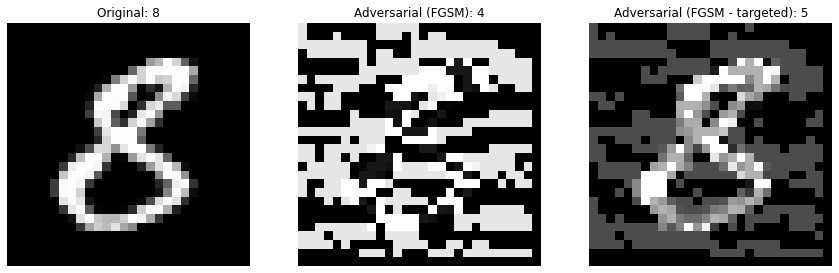

In [15]:
sample = 1234
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(x_test[sample].reshape((28, 28)), cmap='gray', interpolation='none')
ax.set_title("Original: {}".format(np.argmax(y_test[sample])))
ax.axis('off')
ax = fig.add_subplot(1, 4, 2)
ax.imshow(best[2][sample].reshape((28, 28)), cmap='gray', interpolation='none')
ax.set_title("Adversarial (FGSM): {}".format(np.argmax(best[3][sample])))
ax.axis('off')
ax = fig.add_subplot(1, 4, 3)
ax.imshow(best_targeted[2][sample].reshape((28, 28)), cmap='gray', interpolation='none')
ax.set_title("Adversarial (FGSM - targeted): {}".format(np.argmax(best_targeted[3][sample])))
ax.axis('off')
fig.show()

## Otros métodos de ataque

In [16]:
# Más métodos se pueden encontrar en 
# https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html

# Estos métodos tardan bastante más tiempo en ejecutar.

# JSMA
# attack_jsma = SaliencyMapMethod(classifier = classifier, theta = 0.1)
# x_test_jsma = attack_jsma.generate(x=x_test)

# Carlini&Wagner
# attack_cw2 = CarliniL2Method(classifier = classifier)
# x_test_cw2 = attack_cw2.generate(x=x_test)

## Entrenamiento adversario

In [17]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [18]:
attack_fgm = FastGradientMethod(estimator = classifier, eps = 0.6)
x_train_fgm = attack_fgm.generate(x=x_train)
x_test_fgm = attack_fgm.generate(x=x_test)

In [19]:
x_train = np.append(x_train, x_train_fgm, axis=0)
y_train = np.append(y_train, y_train, axis=0)

In [20]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

Train on 120000 samples
Epoch 1/3
120000/120000 [==============================] - 5s 42us/sample - loss: 0.3439 - accuracy: 0.8920
Epoch 2/3
120000/120000 [==============================] - 5s 40us/sample - loss: 0.2003 - accuracy: 0.9398
Epoch 3/3
120000/120000 [==============================] - 5s 40us/sample - loss: 0.1799 - accuracy: 0.9475


In [21]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {0:.2f}%".format(accuracy * 100))

predictions_fsm = classifier.predict(x_test_fgm)
accuracy = np.sum(np.argmax(predictions_fsm, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples for FSGM attack: {0:.2f}%".format(accuracy * 100))

Accuracy on test examples: 96.66%
Accuracy on adversarial test examples for FSGM attack: 92.59%


## Entrenamiento adversario de forma nativa

In [22]:
from art.defences.trainer import AdversarialTrainer

In [23]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])

In [24]:
defence = AdversarialTrainer(classifier=classifier, attacks=attack_fgm, ratio=0.6)

In [25]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [26]:
defence.fit(x=x_train, y=y_train, nb_epochs=3)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {0:.2f}%".format(accuracy * 100))

predictions_fgm = defence.predict(x_test_fgm)
accuracy = np.sum(np.argmax(predictions_fgm, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples for FGM attack: {0:.2f}%".format(accuracy * 100))

Accuracy on test examples: 97.24%
Accuracy on adversarial test examples for FGM attack: 74.65%
